In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2, copy
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np

### Plotting imports ###
import seaborn as sns
from seaborn_patch import SeabornFig2Grid as sfg
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_context("notebook")
sns.set_theme(style="ticks", palette="muted")
%matplotlib inline

/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


# Finding the best masking parameters

This notebook is for extracting and plotting the results of the alignment optimization using a grid search of reference sequence masking tuning parameters.

Results of the grid search was generated in `alignment-opti.ipynb`

In [2]:
# Read the grid optimization results:
align_df = pd.read_csv('align-opti_res.csv')
mask = ~align_df['unique_anno'].isna()
align_df['unique_anno_str'] = [v if pd.isna(v) else str(v) for v in align_df['unique_anno'].values]
align_df['unique_anno_float'] = align_df['unique_anno'] * 1.0
align_df.head(3)

,sample_name_unique,Mapping_percent,percent_single_annotation,percent_multiple_codons,unique_anno,frac_max_score,min_mut_freq,iteration,unique_anno_str,unique_anno_float
0,0m_1,99.324165,68.288596,10.227773,NaN,NaN,NaN,NaN,NaN,NaN
1,8m_1,99.370212,68.516971,10.243350,NaN,NaN,NaN,NaN,NaN,NaN
2,32m_1,98.740267,66.605106,13.571769,NaN,NaN,NaN,NaN,NaN,NaN


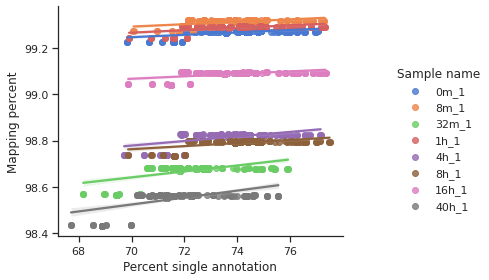

In [3]:
# Is there a trade-off between mapping success
# and annotation uniqueness?
# Looks like the answer is no:
g1 = sns.lmplot(data=align_df[mask], y='Mapping_percent', x='percent_single_annotation', \
                hue='sample_name_unique', aspect=1.3, height=4)
g1.ax.set_xlabel('Percent single annotation')
g1.ax.set_ylabel('Mapping percent')
g1.legend.set_title('Sample name')
g1.savefig('plots/map_trade-off_anno.pdf', bbox_inches='tight')
g1.savefig('plots/map_trade-off_anno.png', bbox_inches='tight', dpi=300)

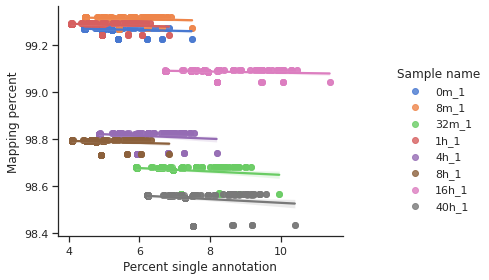

In [4]:
# Is there a trade-off between mapping success
# and percent multiple codon annotation?
# Looks like the answer is no:
g1 = sns.lmplot(data=align_df[mask], y='Mapping_percent', x='percent_multiple_codons', \
                hue='sample_name_unique', aspect=1.3, height=4)
g1.ax.set_xlabel('Percent single annotation')
g1.ax.set_ylabel('Mapping percent')
g1.legend.set_title('Sample name')
g1.savefig('plots/map_trade-off_codon.pdf', bbox_inches='tight')
g1.savefig('plots/map_trade-off_codon.png', bbox_inches='tight', dpi=300)

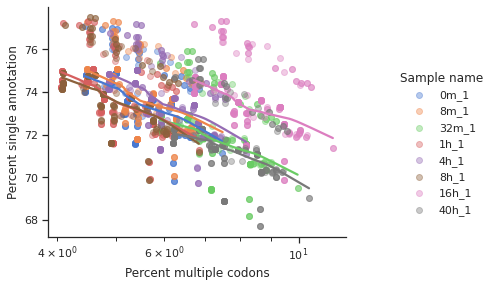

In [5]:
# Is there a correlation between annotation uniqueness
# and percent multiple codons:
g1 = sns.lmplot(data=align_df[mask], y='percent_single_annotation', x='percent_multiple_codons', \
                hue='sample_name_unique', aspect=1.3, height=4, lowess=True, scatter_kws={'alpha':0.4})
g1.ax.set(xscale="log")
g1.ax.set_ylabel('Percent single annotation')
g1.ax.set_xlabel('Percent multiple codons')
g1.legend.set_title('Sample name')
g1.savefig('plots/correlation_anno-codon.pdf', bbox_inches='tight')
g1.savefig('plots/correlation_anno-codon.png', bbox_inches='tight', dpi=300)

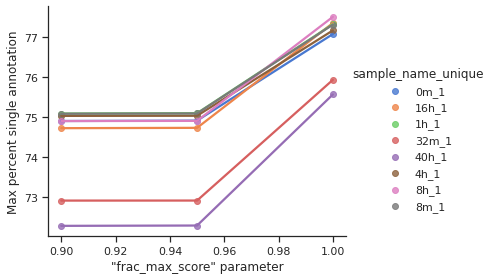

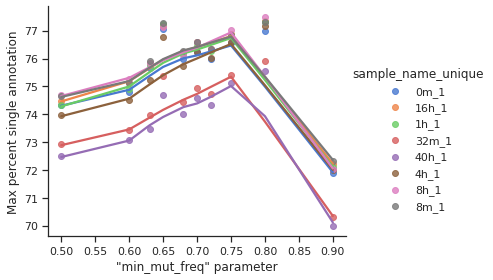

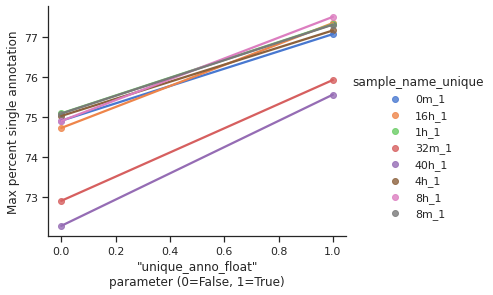

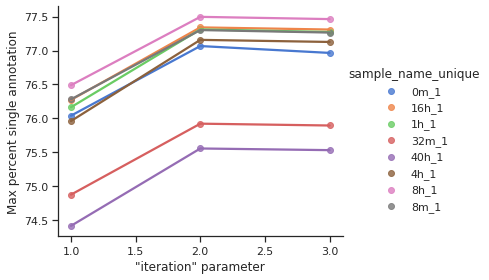

In [6]:
# Use data aggregation to find the max percentage
# of single annotations accross all optimized parameters
# but with the same "frac_max_score" paramter:
fmc_max_agg = align_df[mask].groupby(['sample_name_unique', 'frac_max_score']).agg({'percent_single_annotation': 'max'}).reset_index()

# Plot the aggregation results:
fmc_fig = sns.lmplot(data=fmc_max_agg, x='frac_max_score', y='percent_single_annotation', \
                hue='sample_name_unique', ci=None, aspect=1.3, height=4, lowess=True)
fmc_fig.ax.set_xlabel('"frac_max_score" parameter')
fmc_fig.ax.set_ylabel('Max percent single annotation');

# Now aggregate on the "min_mut_freq" parameter:
mm_max_agg = align_df[mask].groupby(['sample_name_unique', 'min_mut_freq']).agg({'percent_single_annotation': 'max'}).reset_index()
mm_fig = sns.lmplot(data=mm_max_agg, x='min_mut_freq', y='percent_single_annotation', \
                hue='sample_name_unique', ci=None, aspect=1.3, height=4, lowess=True)
mm_fig.ax.set_xlabel('"min_mut_freq" parameter')
mm_fig.ax.set_ylabel('Max percent single annotation');

# Now aggregate on the "unique_anno" parameter:
ua_max_agg = align_df[mask].groupby(['sample_name_unique', 'unique_anno_float']).agg({'percent_single_annotation': 'max'}).reset_index()
ua_fig = sns.lmplot(data=ua_max_agg, x='unique_anno_float', y='percent_single_annotation', \
                hue='sample_name_unique', ci=None, aspect=1.3, height=4, lowess=True)
ua_fig.ax.set_xlabel('"unique_anno_float"\nparameter (0=False, 1=True)')
ua_fig.ax.set_ylabel('Max percent single annotation');

# Now aggregate on the "iteration" parameter:
it_max_agg = align_df[mask].groupby(['sample_name_unique', 'iteration']).agg({'percent_single_annotation': 'max'}).reset_index()
it_fig = sns.lmplot(data=it_max_agg, x='iteration', y='percent_single_annotation', \
                hue='sample_name_unique', ci=None, aspect=1.3, height=4, lowess=True)
it_fig.ax.set_xlabel('"iteration" parameter')
it_fig.ax.set_ylabel('Max percent single annotation');

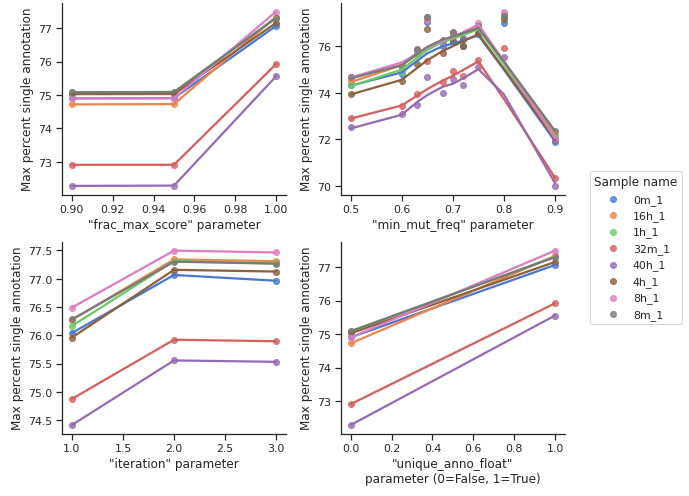

In [7]:
# Collect the above into one plot:
fig = plt.figure(figsize=(8, 7))
gs = gridspec.GridSpec(2, 2)

# Using the Seaborn patch to combine plots:
mg0 = sfg(fmc_fig, fig, gs[0])
mg1 = sfg(mm_fig, fig, gs[1])
mg2 = sfg(ua_fig, fig, gs[3])
mg3 = sfg(it_fig, fig, gs[2])

# Make legend:
handles = it_fig._legend_data.values()
labels = it_fig._legend_data.keys()
fig.legend(title='Sample name', handles=handles, labels=labels, loc='center right', \
           ncol=1, bbox_to_anchor = (1.2, 0.5))

gs.tight_layout(fig)
fig.savefig('plots/align-opti_params_anno.pdf', bbox_inches='tight')

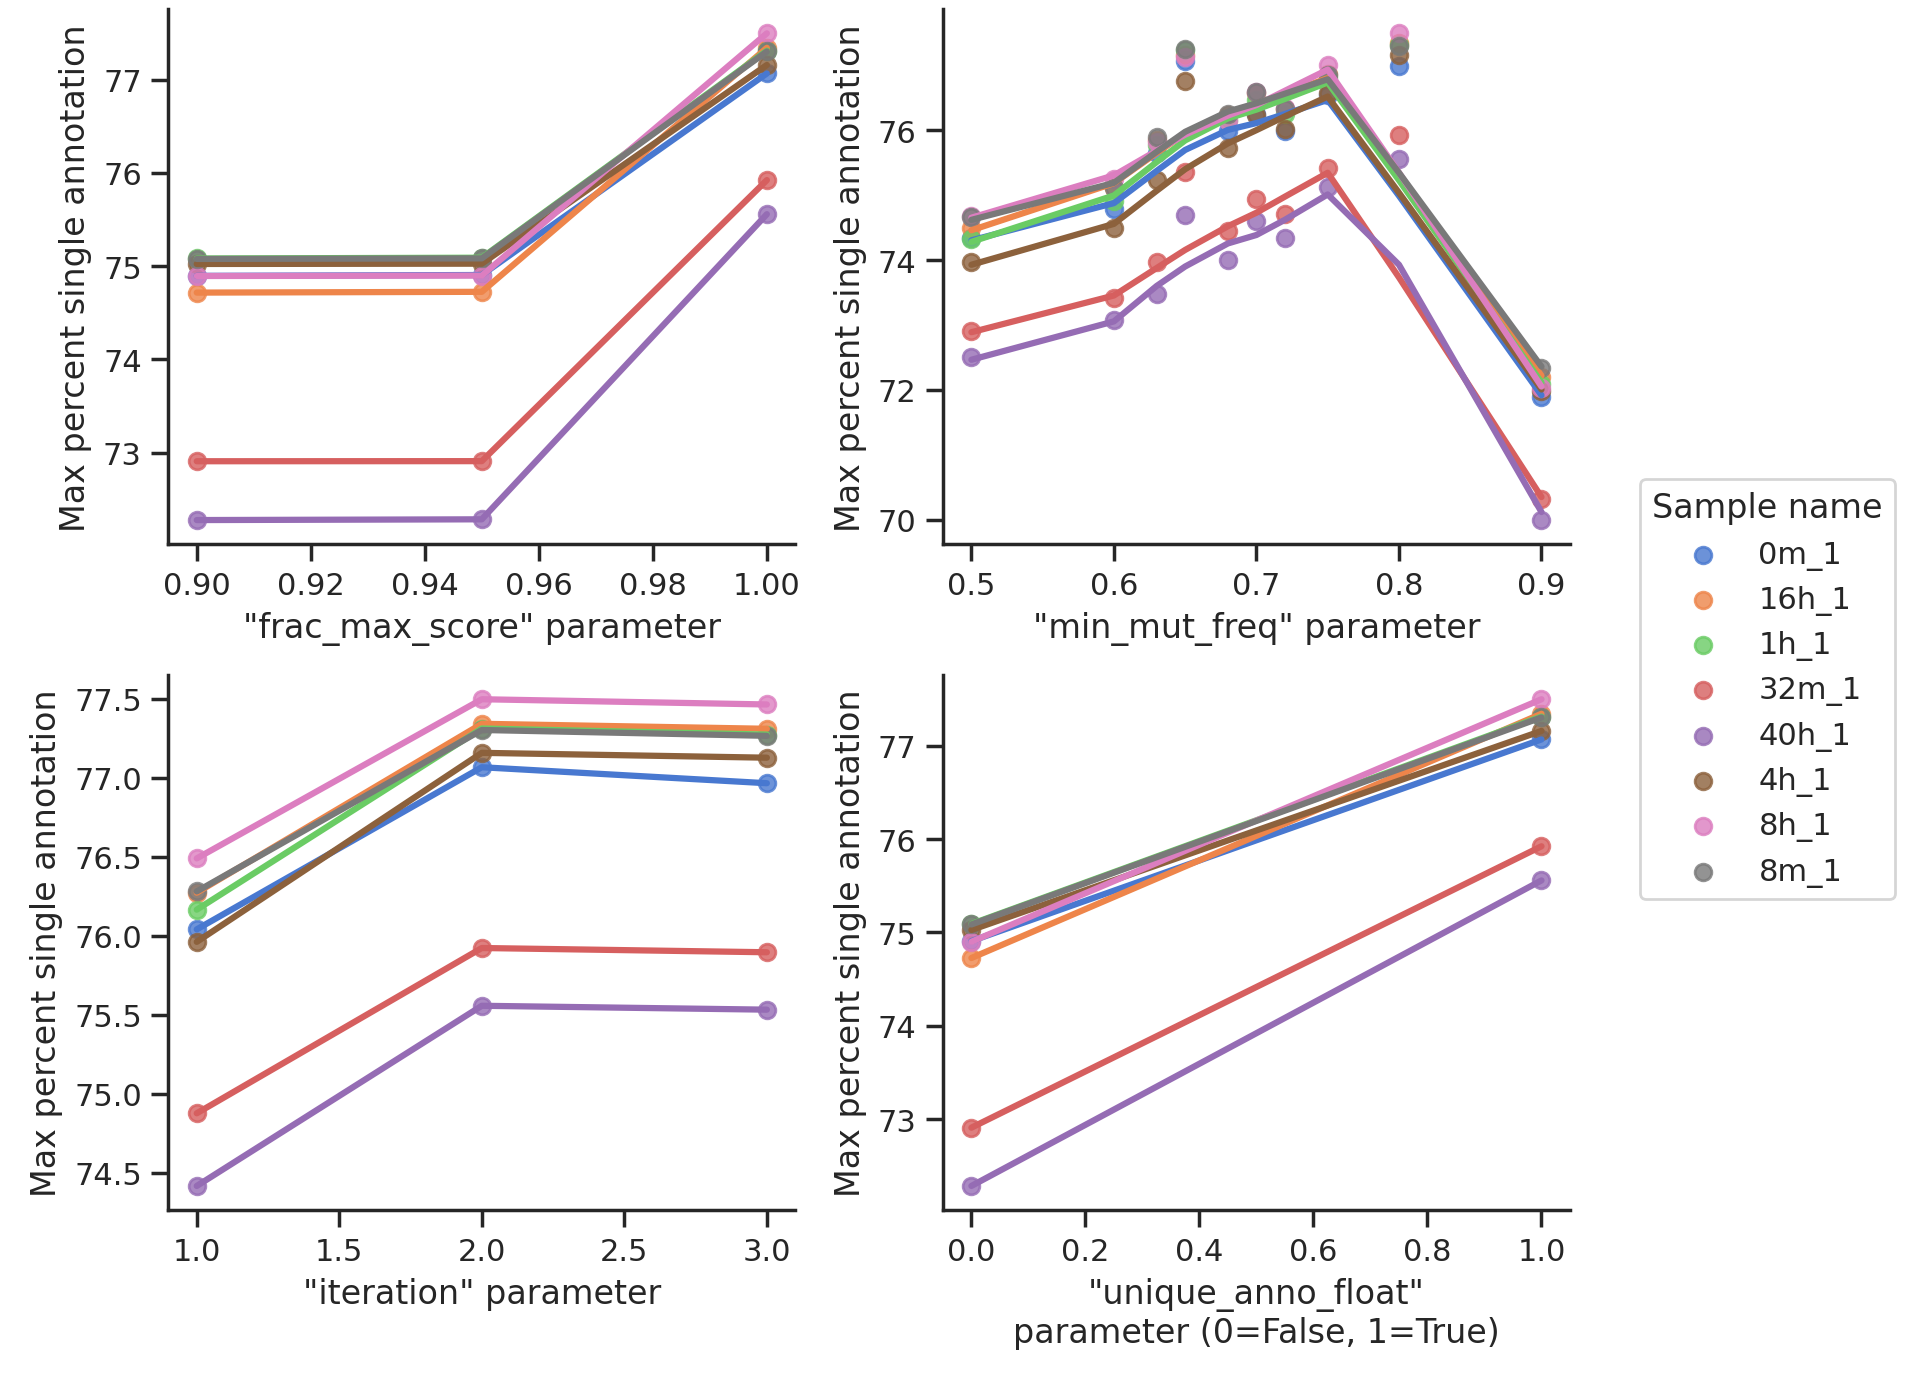

In [8]:
# dpi paramter does not work b/c the Seaborn patch
# does not change dpi settings on the copied axes:

# Below fixes that by changing the dpi settings
# for all figures:

fig = plt.figure(figsize=(8, 7))
fig.set_dpi(200)
gs = gridspec.GridSpec(2, 2)

fmc_fig.fig.set_dpi(200)
mm_fig.fig.set_dpi(200)
ua_fig.fig.set_dpi(200)
it_fig.fig.set_dpi(200)

# Using the Seaborn patch to combine plots:
mg0 = sfg(fmc_fig, fig, gs[0])
mg1 = sfg(mm_fig, fig, gs[1])
mg2 = sfg(ua_fig, fig, gs[3])
mg3 = sfg(it_fig, fig, gs[2])

# Make legend:
handles = it_fig._legend_data.values()
labels = it_fig._legend_data.keys()
fig.legend(title='Sample name', handles=handles, labels=labels, loc='center right', \
           ncol=1, bbox_to_anchor = (1.2, 0.5))

gs.tight_layout(fig)

fig.savefig('plots/align-opti_params_anno.png', bbox_inches='tight', dpi=200)

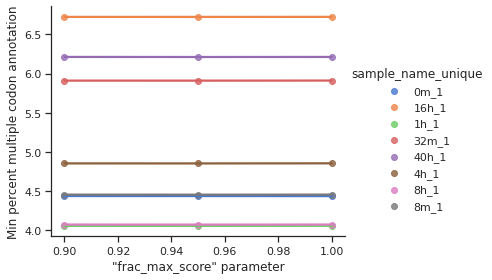

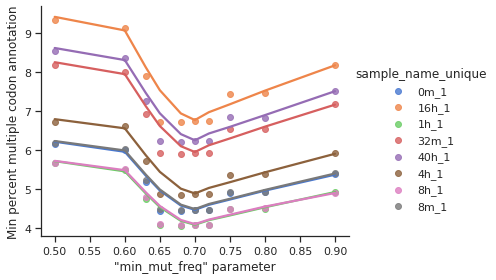

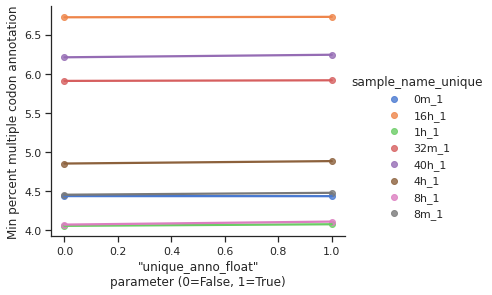

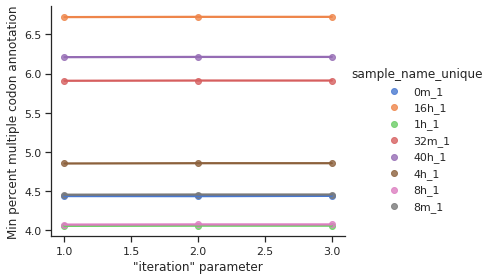

In [9]:
# Use data aggregation to find the min percentage
# of multiple codon annotation accross all optimized parameters
# but with the same "frac_max_score" paramter:
fmc_min_agg = align_df[mask].groupby(['sample_name_unique', 'frac_max_score']).agg({'percent_multiple_codons': 'min'}).reset_index()

# Plot the aggregation results:
fmc_fig = sns.lmplot(data=fmc_min_agg, x='frac_max_score', y='percent_multiple_codons', \
                hue='sample_name_unique', ci=None, aspect=1.3, height=4, lowess=True)
fmc_fig.ax.set_xlabel('"frac_max_score" parameter')
fmc_fig.ax.set_ylabel('Min percent multiple codon annotation');

# Now aggregate on the "min_mut_freq" parameter:
mm_min_agg = align_df[mask].groupby(['sample_name_unique', 'min_mut_freq']).agg({'percent_multiple_codons': 'min'}).reset_index()
mm_fig = sns.lmplot(data=mm_min_agg, x='min_mut_freq', y='percent_multiple_codons', \
                hue='sample_name_unique', ci=None, aspect=1.3, height=4, lowess=True)
mm_fig.ax.set_xlabel('"min_mut_freq" parameter')
mm_fig.ax.set_ylabel('Min percent multiple codon annotation');

# Now aggregate on the "unique_anno" parameter:
ua_min_agg = align_df[mask].groupby(['sample_name_unique', 'unique_anno_float']).agg({'percent_multiple_codons': 'min'}).reset_index()
ua_fig = sns.lmplot(data=ua_min_agg, x='unique_anno_float', y='percent_multiple_codons', \
                hue='sample_name_unique', ci=None, aspect=1.3, height=4, lowess=True)
ua_fig.ax.set_xlabel('"unique_anno_float"\nparameter (0=False, 1=True)')
ua_fig.ax.set_ylabel('Min percent multiple codon annotation');

# Now aggregate on the "iteration" parameter:
it_min_agg = align_df[mask].groupby(['sample_name_unique', 'iteration']).agg({'percent_multiple_codons': 'min'}).reset_index()
it_fig = sns.lmplot(data=it_min_agg, x='iteration', y='percent_multiple_codons', \
                hue='sample_name_unique', ci=None, aspect=1.3, height=4, lowess=True)
it_fig.ax.set_xlabel('"iteration" parameter')
it_fig.ax.set_ylabel('Min percent multiple codon annotation');

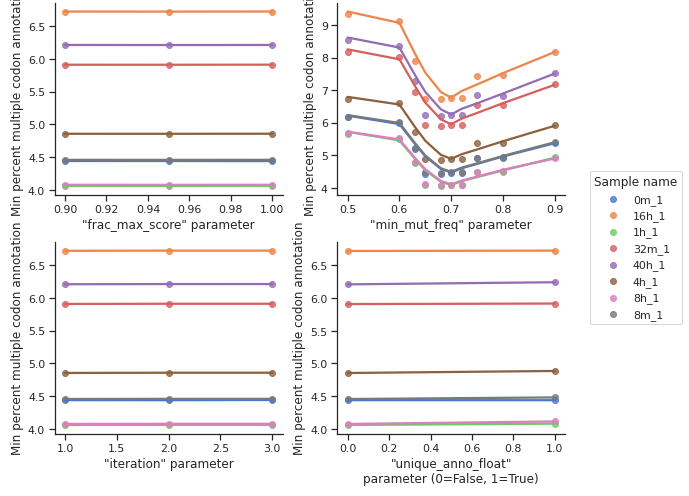

In [10]:
# Collect the above into one plot:
fig = plt.figure(figsize=(8, 7))
gs = gridspec.GridSpec(2, 2)

# Using the Seaborn patch to combine plots:
mg0 = sfg(fmc_fig, fig, gs[0])
mg1 = sfg(mm_fig, fig, gs[1])
mg2 = sfg(ua_fig, fig, gs[3])
mg3 = sfg(it_fig, fig, gs[2])

# Make legend:
handles = it_fig._legend_data.values()
labels = it_fig._legend_data.keys()
fig.legend(title='Sample name', handles=handles, labels=labels, loc='center right', \
           ncol=1, bbox_to_anchor = (1.2, 0.5))

gs.tight_layout(fig)
fig.savefig('plots/align-opti_params_codon.pdf', bbox_inches='tight')

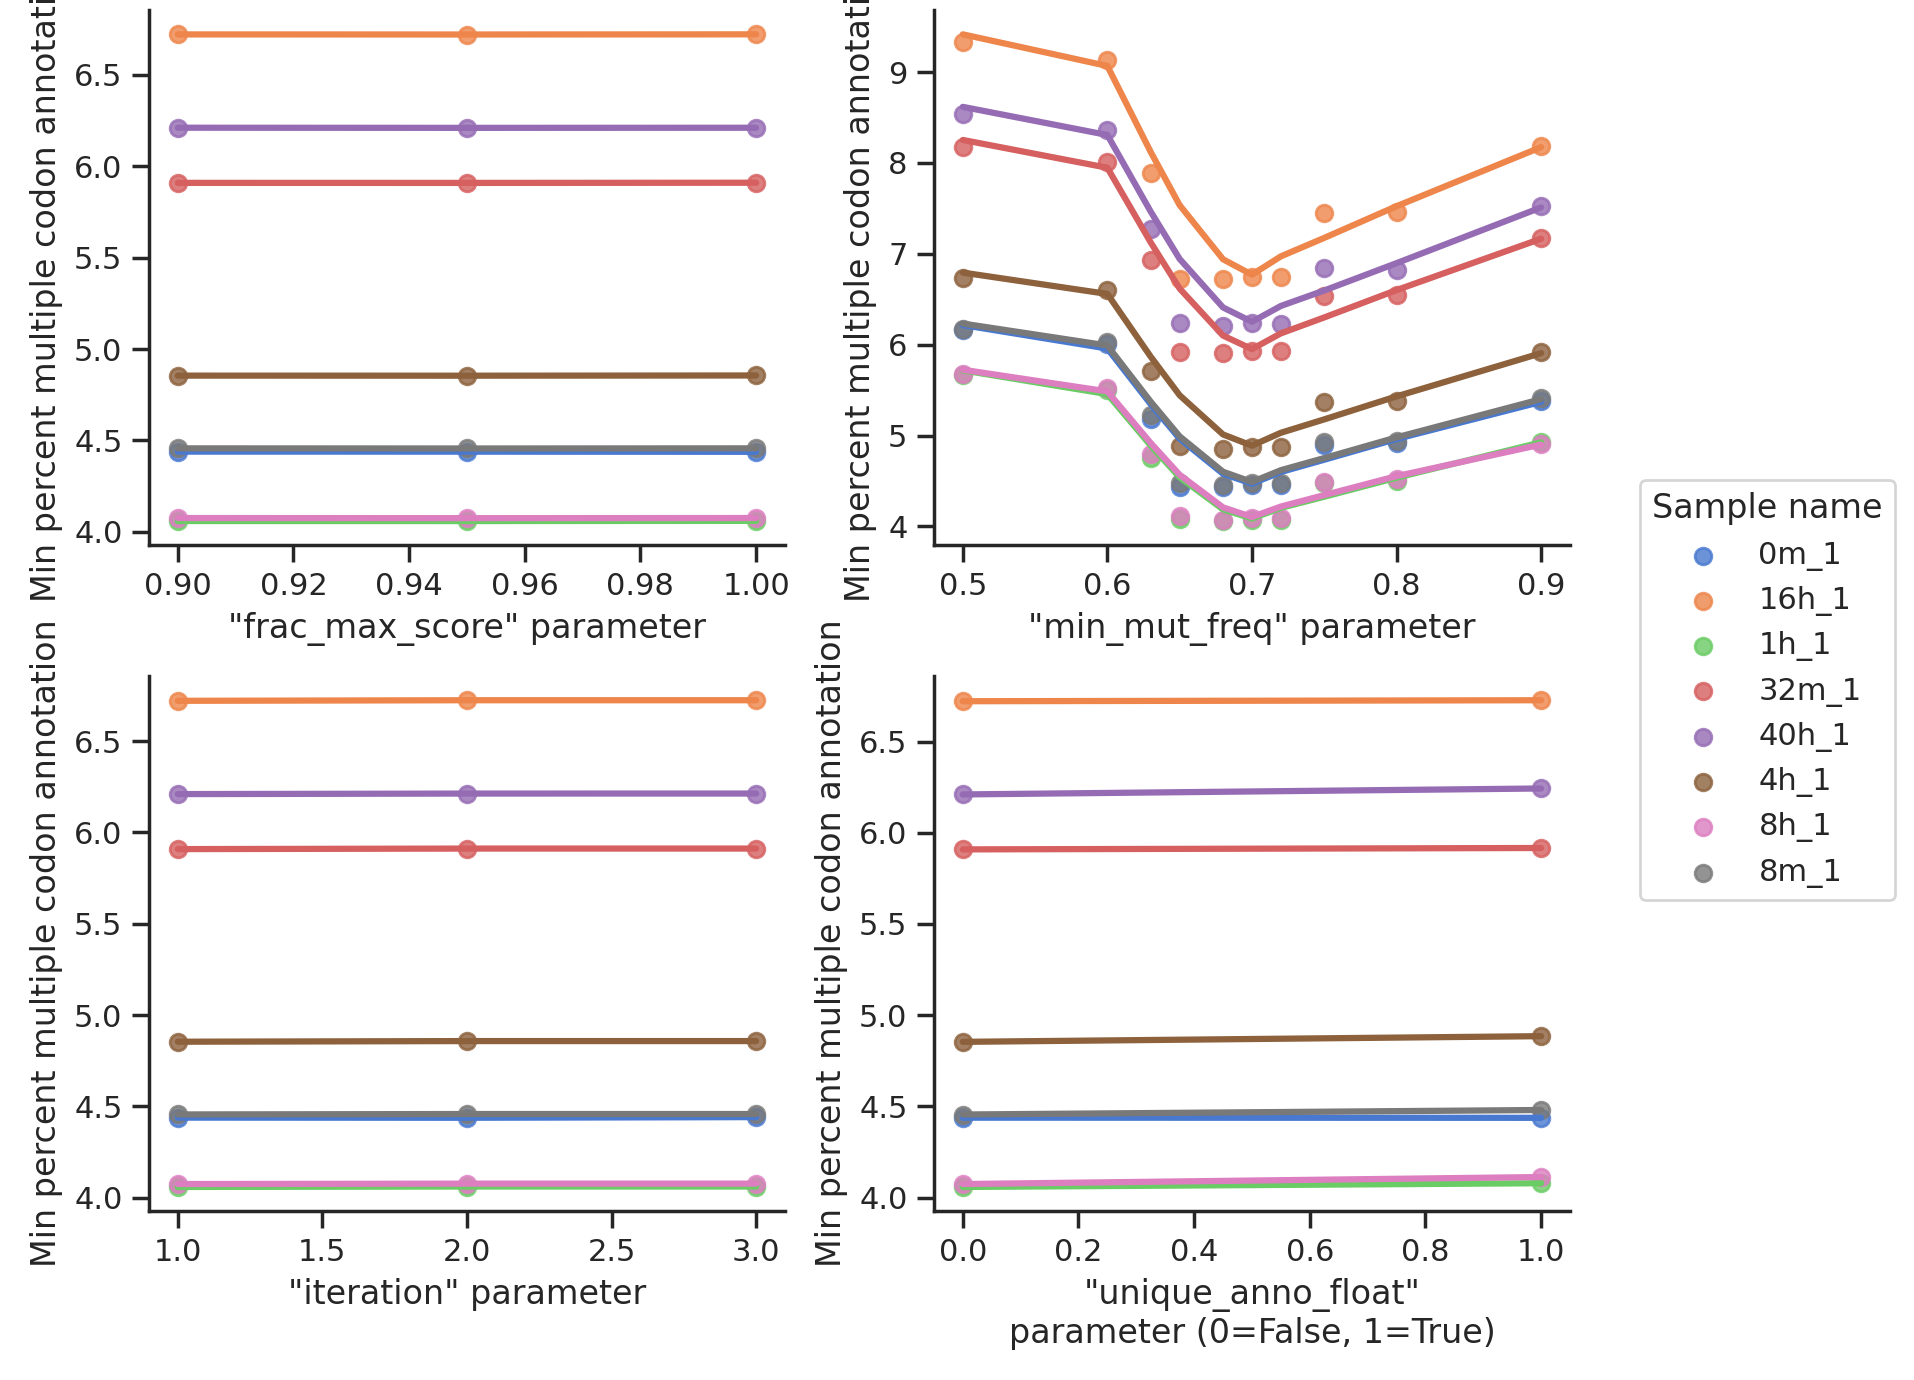

In [11]:
# dpi paramter does not work b/c the Seaborn patch
# does not change dpi settings on the copied axes:

# Below fixes that by changing the dpi settings
# for all figures:

fig = plt.figure(figsize=(8, 7))
fig.set_dpi(200)
gs = gridspec.GridSpec(2, 2)

fmc_fig.fig.set_dpi(200)
mm_fig.fig.set_dpi(200)
ua_fig.fig.set_dpi(200)
it_fig.fig.set_dpi(200)

# Using the Seaborn patch to combine plots:
mg0 = sfg(fmc_fig, fig, gs[0])
mg1 = sfg(mm_fig, fig, gs[1])
mg2 = sfg(ua_fig, fig, gs[3])
mg3 = sfg(it_fig, fig, gs[2])

# Make legend:
handles = it_fig._legend_data.values()
labels = it_fig._legend_data.keys()
fig.legend(title='Sample name', handles=handles, labels=labels, loc='center right', \
           ncol=1, bbox_to_anchor = (1.2, 0.5))

gs.tight_layout(fig)

fig.savefig('plots/align-opti_params_codon.png', bbox_inches='tight', dpi=200)

In [12]:
# Find the best alignment parameter combination
# for each sample for increasing mapping uniqueness:
best_res = align_df[mask].groupby(['sample_name_unique']).agg({'percent_single_annotation': 'max'}).reset_index()

max_row_list = list()
for _, row in best_res.iterrows():
    snu_mask = align_df['sample_name_unique'] == row['sample_name_unique']
    sam_ser = align_df.loc[snu_mask, 'percent_single_annotation']
    max_idx = sam_ser[sam_ser == row['percent_single_annotation']].index.values
    
    for mid in max_idx:
        max_row_list.append(align_df.loc[mid, :])

# Make rows into dataframe and extract max iteration
# if two iterations have the same "percent_single_annotation":
best_df = pd.DataFrame(max_row_list)
best_df_grp = best_df.groupby(['sample_name_unique', 'Mapping_percent', \
                               'percent_single_annotation', 'unique_anno', \
                               'frac_max_score', 'min_mut_freq']).agg({'iteration': 'max'}).reset_index()
# Find and count all the parameter combinations:
pivot_cols = ['unique_anno', 'iteration', 'frac_max_score', 'min_mut_freq']
param_combi = pd.pivot_table(best_df_grp.loc[:, pivot_cols], \
                             index=pivot_cols, aggfunc='size')
param_combi = param_combi.to_frame().reset_index().rename(columns={0: 'Count'})

In [13]:
best_df_grp

,sample_name_unique,Mapping_percent,percent_single_annotation,unique_anno,frac_max_score,min_mut_freq,iteration
0,0m_1,99.272329,77.066197,True,1.0,0.65,2.0
1,16h_1,99.092084,77.341052,True,1.0,0.80,2.0
2,1h_1,99.291512,77.311236,True,1.0,0.80,2.0
3,32m_1,98.679062,75.922575,True,1.0,0.80,2.0
4,40h_1,98.560396,75.557070,True,1.0,0.80,2.0
5,4h_1,98.823353,77.157263,True,1.0,0.80,2.0
6,8h_1,98.793824,77.496413,True,1.0,0.80,2.0
7,8m_1,99.317618,77.301858,True,1.0,0.80,2.0


In [14]:
param_combi

,unique_anno,iteration,frac_max_score,min_mut_freq,Count
0,True,2.0,1.0,0.65,1
1,True,2.0,1.0,0.80,7


In [15]:
# Find the best alignment parameter combination
# for each sample for decreasing multiple codon alignment:
best_res = align_df[mask].groupby(['sample_name_unique']).agg({'percent_multiple_codons': 'min'}).reset_index()

max_row_list = list()
for _, row in best_res.iterrows():
    snu_mask = align_df['sample_name_unique'] == row['sample_name_unique']
    sam_ser = align_df.loc[snu_mask, 'percent_multiple_codons']
    max_idx = sam_ser[sam_ser == row['percent_multiple_codons']].index.values
    
    for mid in max_idx:
        max_row_list.append(align_df.loc[mid, :])

# Make rows into dataframe and extract max iteration
# if two iterations have the same "percent_multiple_codons":
best_df = pd.DataFrame(max_row_list)
best_df_grp = best_df.groupby(['sample_name_unique', 'Mapping_percent', \
                               'percent_multiple_codons', 'unique_anno', \
                               'frac_max_score', 'min_mut_freq']).agg({'iteration': 'max'}).reset_index()
# Find and count all the parameter combinations:
pivot_cols = ['unique_anno', 'iteration', 'frac_max_score', 'min_mut_freq']
param_combi = pd.pivot_table(best_df_grp.loc[:, pivot_cols], \
                             index=pivot_cols, aggfunc='size')
param_combi = param_combi.to_frame().reset_index().rename(columns={0: 'Count'})

In [16]:
best_df_grp

,sample_name_unique,Mapping_percent,percent_multiple_codons,unique_anno,frac_max_score,min_mut_freq,iteration
0,0m_1,99.272329,4.437436,True,1.00,0.65,2.0
1,16h_1,99.091935,6.721121,False,0.95,0.68,1.0
2,1h_1,99.291669,4.058439,False,0.95,0.68,1.0
3,32m_1,98.680070,5.908935,False,0.95,0.68,1.0
4,40h_1,98.561703,6.210220,False,0.95,0.68,1.0
5,4h_1,98.823837,4.853960,False,0.95,0.68,1.0
6,8h_1,98.795492,4.074359,False,0.95,0.68,1.0
7,8m_1,99.318155,4.455651,False,0.95,0.68,1.0


In [17]:
param_combi

,unique_anno,iteration,frac_max_score,min_mut_freq,Count
0,False,1.0,0.95,0.68,7
1,True,2.0,1.00,0.65,1


In [18]:
# Printing the alignment stats
# using the unmasked tRNA database:
align_df[~mask]

,sample_name_unique,Mapping_percent,percent_single_annotation,percent_multiple_codons,unique_anno,frac_max_score,min_mut_freq,iteration,unique_anno_str,unique_anno_float
0,0m_1,99.324165,68.288596,10.227773,NaN,NaN,NaN,NaN,NaN,NaN
1,8m_1,99.370212,68.516971,10.243350,NaN,NaN,NaN,NaN,NaN,NaN
2,32m_1,98.740267,66.605106,13.571769,NaN,NaN,NaN,NaN,NaN,NaN
3,1h_1,99.318882,68.242731,9.346941,NaN,NaN,NaN,NaN,NaN,NaN
4,4h_1,98.833330,68.068678,11.178913,NaN,NaN,NaN,NaN,NaN,NaN
5,8h_1,98.849693,68.199418,9.393985,NaN,NaN,NaN,NaN,NaN,NaN
6,16h_1,99.153289,68.300728,15.526773,NaN,NaN,NaN,NaN,NaN,NaN
7,40h_1,98.648370,66.080444,14.152031,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
align_df.loc[~mask, ['Mapping_percent', 'percent_single_annotation', 'percent_multiple_codons']].mean()

Mapping_percent              99.029776
percent_single_annotation    67.787834
percent_multiple_codons      11.705192
dtype: float64

In [21]:
# And then printing these stats for the
# best parameters for minimizing the mapping
# to multiple codons
# (using 3 iterations instead of 1, to get a stable result):
param_choice = (align_df['unique_anno'] == False) & (align_df['iteration'] == 3) & (align_df['frac_max_score'] == 0.95) & (align_df['min_mut_freq'] == 0.68)
align_df[param_choice]

,sample_name_unique,Mapping_percent,percent_single_annotation,percent_multiple_codons,unique_anno,frac_max_score,min_mut_freq,iteration,unique_anno_str,unique_anno_float
1512,0m_1,99.270539,74.027656,4.440943,False,0.95,0.68,3.0,False,0.0
1513,8m_1,99.318155,74.301386,4.457906,False,0.95,0.68,3.0,False,0.0
1514,32m_1,98.680070,72.137738,5.911871,False,0.95,0.68,3.0,False,0.0
1515,1h_1,99.291669,74.222362,4.060808,False,0.95,0.68,3.0,False,0.0
1516,4h_1,98.823837,74.138942,4.857488,False,0.95,0.68,3.0,False,0.0
1517,8h_1,98.795492,74.132849,4.076637,False,0.95,0.68,3.0,False,0.0
1518,16h_1,99.091935,73.952814,6.724284,False,0.95,0.68,3.0,False,0.0
1519,40h_1,98.561703,71.608583,6.213271,False,0.95,0.68,3.0,False,0.0


In [22]:
align_df.loc[param_choice, ['Mapping_percent', 'percent_single_annotation', 'percent_multiple_codons']].mean()

Mapping_percent              98.979175
percent_single_annotation    73.565291
percent_multiple_codons       5.092901
dtype: float64

## Conclusion
The above chosen parameters generated a masked tRNA database resulting in alignment statistics with a negligible decrease in mapping percentage but a large improvement of alignment quality i.e. more unique mapping and much less mapping to multiple codons.